# A simple recommender with tensorflow
> A tutorial on how to build a simple deep learning based movie recommender using tensorflow library.

- toc: true
- badges: true
- comments: true
- categories: [movie, tensorflow]
- image: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

tf.random.set_seed(343)

In [ ]:
# Clean up the logdir if it exists
import shutil
shutil.rmtree('logs', ignore_errors=True)

# Load TensorBoard extension for notebooks
%load_ext tensorboard

In [ ]:
movielens_ratings_file = 'https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_100K_ratings.csv?raw=true'
df_raw = pd.read_csv(movielens_ratings_file)
df_raw.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
df = df_raw.copy()
df.columns = ['userId', 'movieId', 'rating', 'timestamp']
user_ids = df['userId'].unique()
user_encoding = {x: i for i, x in enumerate(user_ids)}   # {user_id: index}
movie_ids = df['movieId'].unique()
movie_encoding = {x: i for i, x in enumerate(movie_ids)} # {movie_id: index}

df['user'] = df['userId'].map(user_encoding)    # Map from IDs to indices
df['movie'] = df['movieId'].map(movie_encoding)

n_users = len(user_ids)
n_movies = len(movie_ids)

min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'Number of users: {n_users}\nNumber of movies: {n_movies}\nMin rating: {min_rating}\nMax rating: {max_rating}')

# Shuffle the data
df = df.sample(frac=1, random_state=42)

Number of users: 943
Number of movies: 1682
Min rating: 1.0
Max rating: 5.0


### Scheme of the model

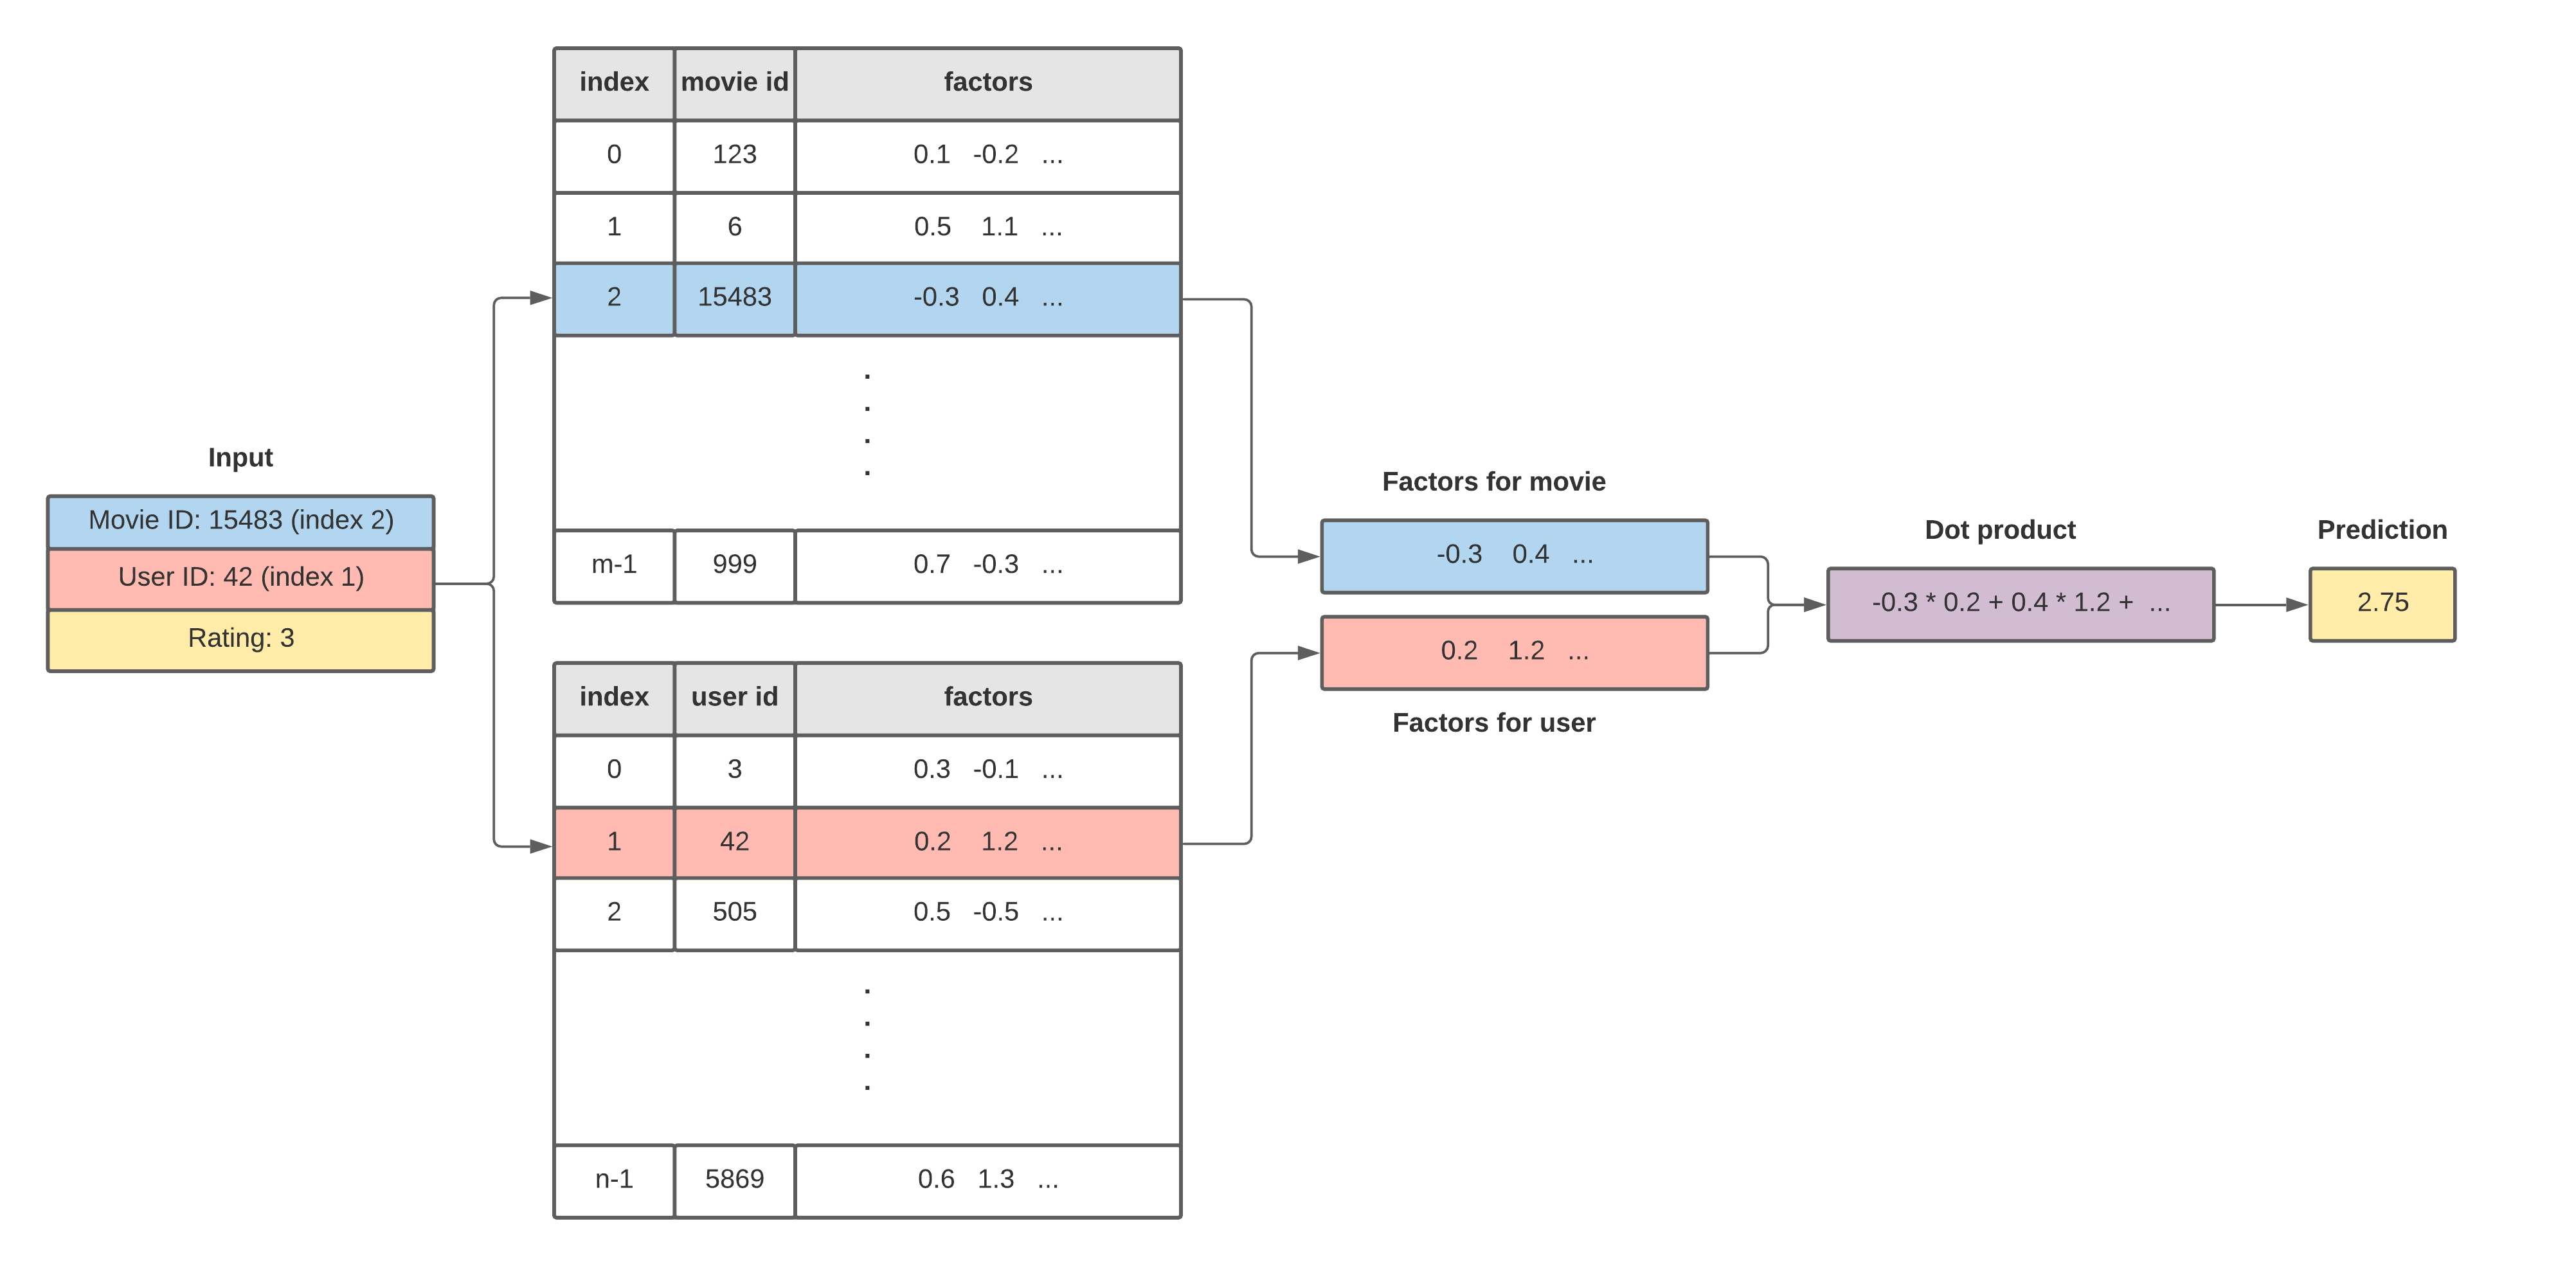

In [ ]:
class MatrixFactorization(models.Model):
    def __init__(self, n_users, n_movies, n_factors, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_movies = n_movies
        self.n_factors = n_factors
        
        # We specify the size of the matrix,
        # the initializer (truncated normal distribution)
        # and the regularization type and strength (L2 with lambda = 1e-6)
        self.user_emb = layers.Embedding(n_users, 
                                         n_factors, 
                                         embeddings_initializer='he_normal',
                                         embeddings_regularizer=keras.regularizers.l2(1e-6),
                                         name='user_embedding')
        self.movie_emb = layers.Embedding(n_movies, 
                                          n_factors, 
                                          embeddings_initializer='he_normal',
                                          embeddings_regularizer=keras.regularizers.l2(1e-6),
                                          name='movie_embedding')
        
        # Embedding returns a 3D tensor with one dimension = 1, so we reshape it to a 2D tensor
        self.reshape = layers.Reshape((self.n_factors,))
        
        # Dot product of the latent vectors
        self.dot = layers.Dot(axes=1)

    def call(self, inputs):
        # Two inputs
        user, movie = inputs
        u = self.user_emb(user)
        u = self.reshape(u)
    
        m = self.movie_emb(movie)
        m = self.reshape(m)
        
        return self.dot([u, m])

n_factors = 50
model = MatrixFactorization(n_users, n_movies, n_factors)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
try:
    model.summary()
except ValueError as e:
    print(e, type(e))

This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build. <class 'ValueError'>


This is why building models via subclassing is a bit annoying - you can run into errors such as this. We'll fix it by calling the model with some fake data so it knows the shapes of the inputs.

In [ ]:
_ = model([np.array([1, 2, 3]), np.array([2, 88, 5])])
model.summary()

Model: "matrix_factorization_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embedding (Embedding)   multiple                  47150     
_________________________________________________________________
movie_embedding (Embedding)  multiple                  84100     
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
dot_1 (Dot)                  multiple                  0         
Total params: 131,250
Trainable params: 131,250
Non-trainable params: 0
_________________________________________________________________


We're going to expand our toolbox by introducing callbacks. Callbacks can be used to monitor our training progress, decay the learning rate, periodically save the weights or even stop early in case of detected overfitting. In Keras, they are really easy to use: you just create a list of desired callbacks and pass it to the model.fit method. It's also really easy to define your own by subclassing the Callback class. You can also specify when they will be triggered - the default is at the end of every epoch.

We'll use two: an early stopping callback which will monitor our loss and stop the training early if needed and TensorBoard, a utility for visualizing models, monitoring the training progress and much more.

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

history = model.fit(
    x=(df['user'].values, df['movie'].values),  # The model has two inputs!
    y=df['rating'],
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/20
704/704 [==============================] - 3s 3ms/step - loss: 12.0905 - val_loss: 5.5121
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 2.1751 - val_loss: 1.2149
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 1.0271 - val_loss: 0.9839
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.9003 - val_loss: 0.9266
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.8470 - val_loss: 0.8996
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.8046 - val_loss: 0.8786
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.7667 - val_loss: 0.8680
Epoch 8/20
704/704 [==============================] - 2s 3ms/step - loss: 0.7329 - val_loss: 0.8618
Epoch 9/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6999 - val_loss: 0.8558
Epoch 10/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6688 - val_loss: 0.855

We see that we stopped early because the validation loss was not improving. Now, we'll open TensorBoard (it's a separate program called via command-line) to read the written logs and visualize the loss over all epochs. We will also look at how to visualize the model as a computational graph.

In [ ]:
# Run TensorBoard and specify the log dir
%tensorboard --logdir logs

We've seen how easy it is to implement a recommender system with Keras and use a few utilities to make it easier to experiment. Note that this model is still quite basic and we could easily improve it: we could try adding a bias for each user and movie or adding non-linearity by using a sigmoid function and then rescaling the output. It could also be extended to use other features of a user or movie.

Next, we'll try a bigger, more state-of-the-art model: a deep autoencoder.

We'll apply a more advanced algorithm to the same dataset as before, taking a different approach. We'll use a deep autoencoder network, which attempts to reconstruct its input and with that gives us ratings for unseen user / movie pairs.

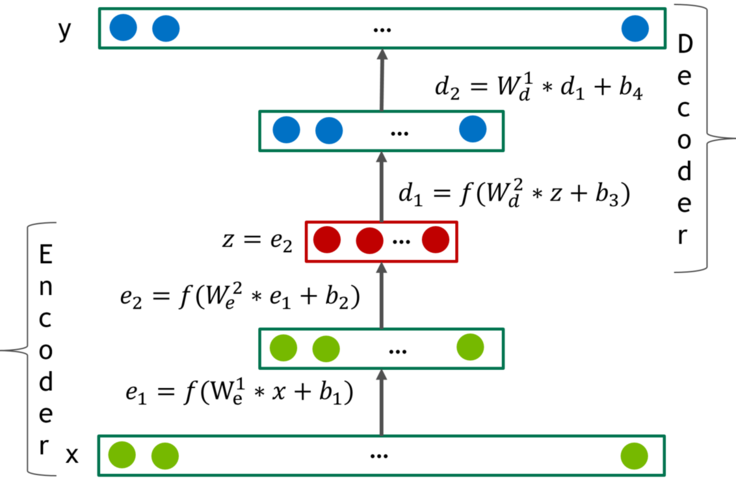

Preprocessing will be a bit different due to the difference in our model. Our autoencoder will take a vector of all ratings for a movie and attempt to reconstruct it. However, our input vector will have a lot of zeroes due to the sparsity of our data. We'll modify our loss so our model won't predict zeroes for those combinations - it will actually predict unseen ratings.

To facilitate this, we'll use the sparse tensor that TF supports. Note: to make training easier, we'll transform it to dense form, which would not work in larger datasets - we would have to preprocess the data in a different way or stream it into the model.

### Sparse representation and autoencoder reconstruction

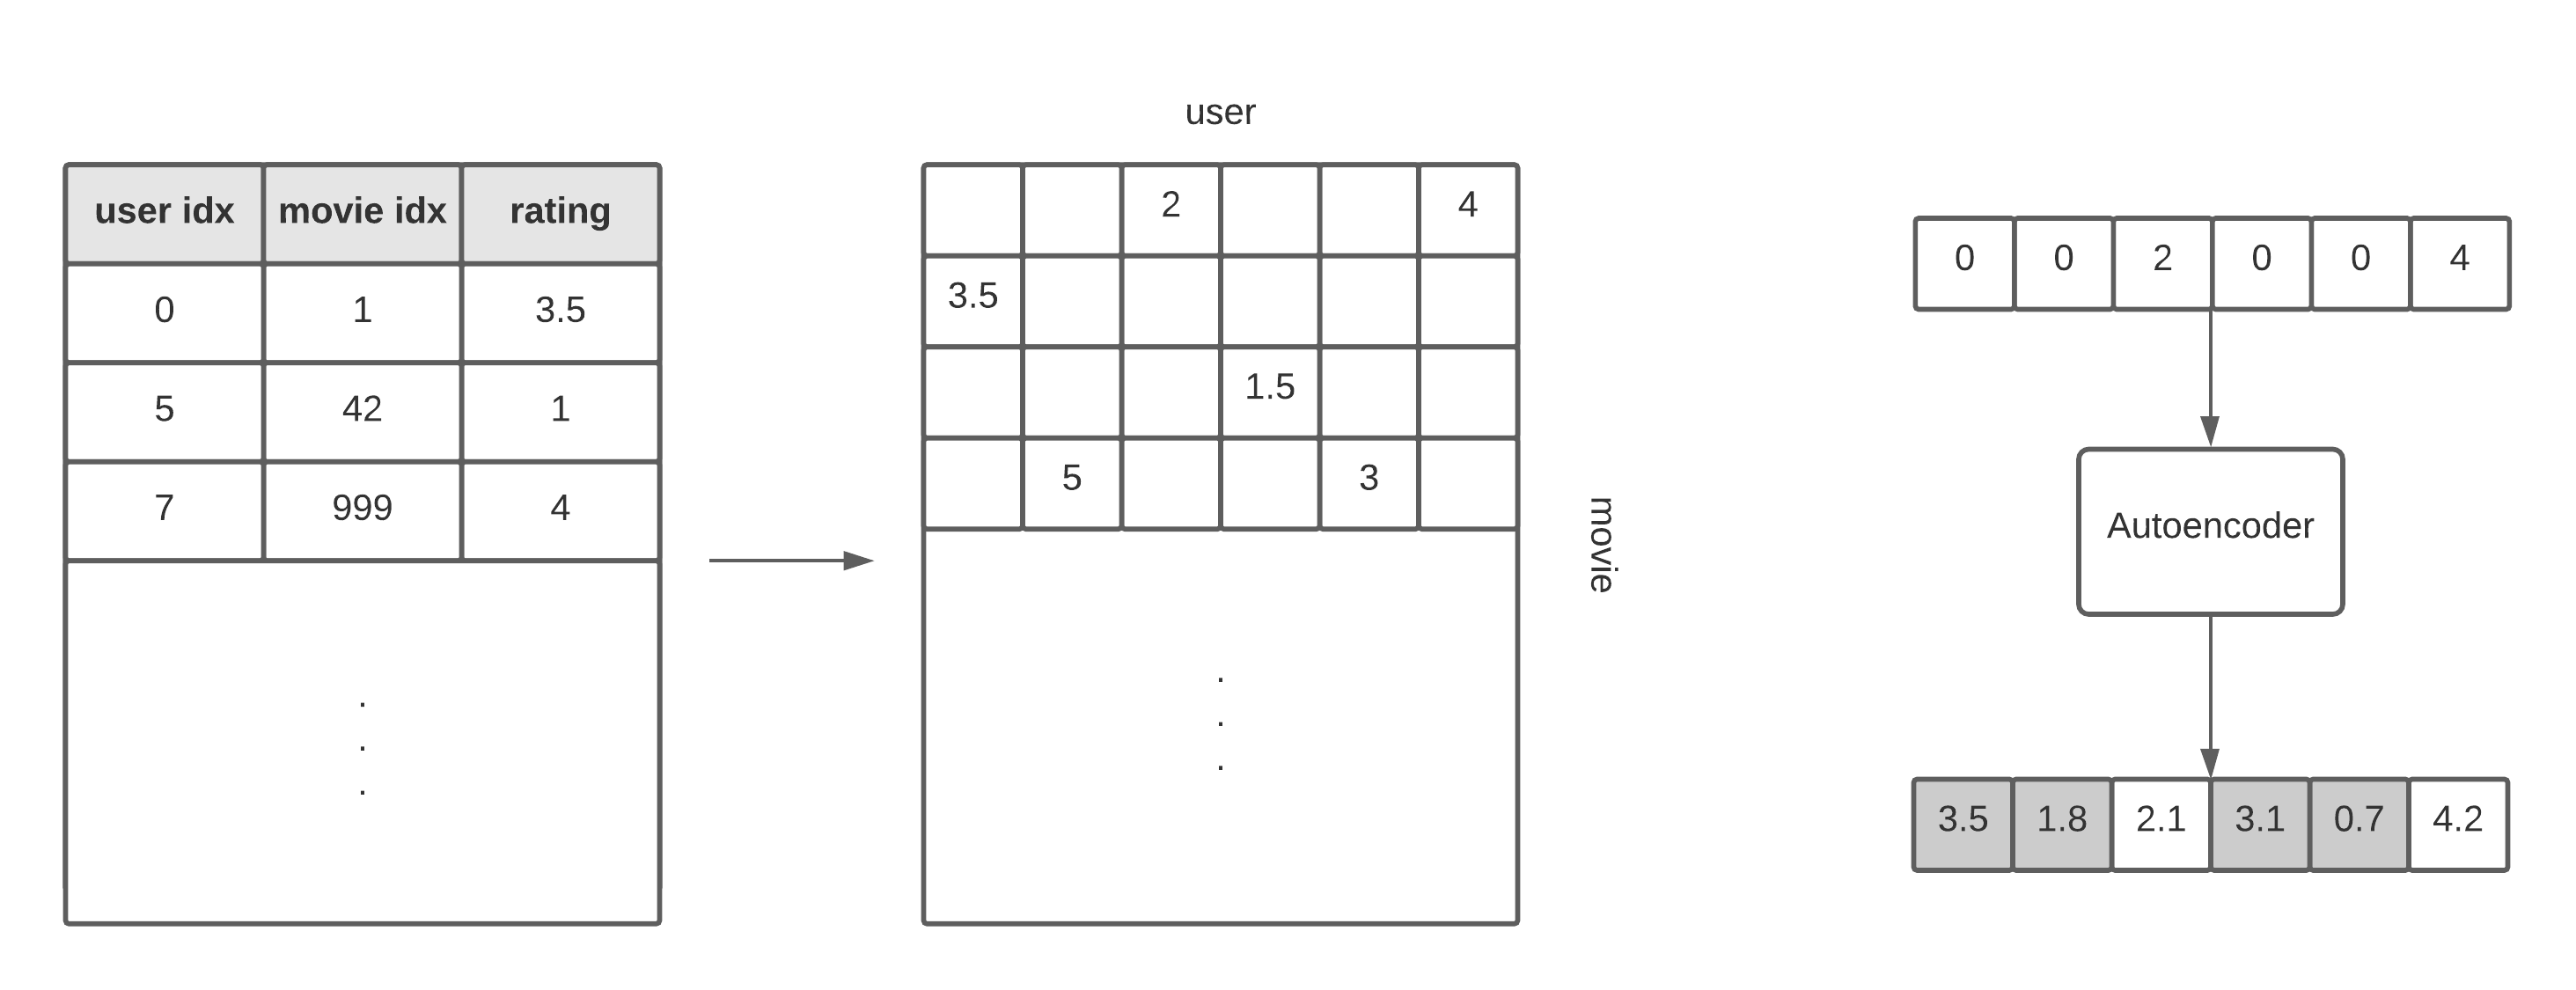

In [ ]:
df_raw.head()

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
# Create a sparse tensor: at each user, movie location, we have a value, the rest is 0
sparse_x = tf.sparse.SparseTensor(indices=df[['movie', 'user']].values, values=df['rating'], dense_shape=(n_movies, n_users))

# Transform it to dense form and to float32 (good enough precision)
dense_x = tf.cast(tf.sparse.to_dense(tf.sparse.reorder(sparse_x)), tf.float32)

# Shuffle the data
x = tf.random.shuffle(dense_x, seed=42)

Now, let's create the model. We'll have to specify the input shape. Because we have 9724 movies and only 610 users, we'll prefer to predict ratings for movies instead of users - this way, our dataset is larger.

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dropout = layers.Dropout(0.3)
        
    def call(self, x):
        d1 = self.dense1(x)
        d2 = self.dense2(d1)
        d3 = self.dense3(d2)
        return self.dropout(d3)
        
        
class Decoder(layers.Layer):
    def __init__(self, n, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(n, activation='selu', kernel_initializer='glorot_uniform')

    def call(self, x):
        d1 = self.dense1(x)
        d2 = self.dense2(d1)
        return self.dense3(d2)

n = n_users
inputs = layers.Input(shape=(n,))

encoder = Encoder()
decoder = Decoder(n)

enc1 = encoder(inputs)
dec1 = decoder(enc1)
enc2 = encoder(dec1)
dec2 = decoder(enc2)

model = models.Model(inputs=inputs, outputs=dec2, name='DeepAutoencoder')
model.summary()

Model: "DeepAutoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 943)]        0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (None, 56)           31248       input_1[0][0]                    
                                                                 decoder[0][0]                    
__________________________________________________________________________________________________
decoder (Decoder)               (None, 943)          32135       encoder[0][0]                    
                                                                 encoder[1][0]                    
Total params: 63,383
Trainable params: 63,383
Non-trainable params: 0
______________

Because our inputs are sparse, we'll need to create a modified mean squared error function. We have to look at which ratings are zero in the ground truth and remove them from our loss calculation (if we didn't, our model would quickly learn to predict zeros almost everywhere). We'll use masking - first get a boolean mask of non-zero values and then extract them from the result.

In [ ]:
def masked_mse(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)
    se = tf.boolean_mask(tf.square(y_true - y_pred), mask)
    return tf.reduce_mean(se)

model.compile(
    loss=masked_mse,
    optimizer=keras.optimizers.Adam()
)

The model training will be similar as before - we'll use early stopping and TensorBoard. Our batch size will be smaller due to the lower number of examples. Note that we are passing the same array for both x and y, because the autoencoder reconstructs its input.

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

model.fit(
    x, 
    x, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/100
95/95 [==============================] - 2s 7ms/step - loss: 4.6136 - val_loss: 1.1074
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 1.1491 - val_loss: 1.0088
Epoch 3/100
95/95 [==============================] - 0s 5ms/step - loss: 1.0577 - val_loss: 0.9768
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 1.0257 - val_loss: 0.9758
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.9971 - val_loss: 0.9774
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.9812 - val_loss: 0.9604
Epoch 7/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9598 - val_loss: 0.9275
Epoch 8/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9501 - val_loss: 0.9253
Epoch 9/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9177 - val_loss: 0.9159
Epoch 10/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9193 - val_loss: 0.9189
Epoch 11/

Let's visualize our loss and the model itself with TensorBoard.

In [ ]:
%tensorboard --logdir logs

That's it! We've seen how to use TensorFlow to implement recommender systems in a few different ways. I hope this short introduction has been informative and has prepared you to use TF on new problems. Thank you for your attention!